In [108]:
%pip install humanfriendly

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [109]:
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  
import humanfriendly
from datetime import timedelta

In [2]:
ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Bounded SED LB',
    'lblint': 'Label Intersection'
}

datasets = ('bolzano', 'dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')

In [3]:
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint'
}

In [101]:
BASEPATH = 'resources/results/'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        join_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(join_times_path):
            print(alg, 'is not computed for', dataset, f'{join_times_path} skipping')
            continue
        df = pd.read_csv(join_times_path, names=["time"])
        
        candidate_eval_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(candidate_eval_times_path):
            print(alg, 'is not computed for', dataset, f'{candidate_eval_times_path} skipping')
            continue
        lb_df = pd.read_csv(candidate_eval_times_path, names=["query_filter_time_us"])
        
        with open(join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')) as f:
            selectivity_line = f.readline()
            rest = f.read()
            
            if not selectivity_line.startswith('Mean selectivi'):
                rest = selectivity_line + rest

        # sel = selectivity_line.split(':')[1]
        # sel = float(sel.rstrip('%\n'))
        # print(sel)
        # seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, lb_df]
    return algorithm_times

In [102]:
# tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]
tested_values= [('bolzano', 6), ('sentiment', 10), ('ptb', 15), ('treefam', 60), ('python', 15), ('dblp', 6)]

In [103]:
dataframes = dict()
for ds, t in tested_values:
    try:
        dataframes[ds] = load_dataset(ds, t)
    except Exception:
        print('Failed getting results from ', ds)

In [104]:
selectivities = [ (ds, float(dataframes[ds]['sed'][1]['Mean Selectivity'][0].rstrip('%') ), t) for ds, t in tested_values ]
selectivity_df = pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])
selectivity_df

,Dataset,Mean query selectivity %,Threshold
0,bolzano,0.44922,6
1,sentiment,0.34211,10
2,ptb,0.07664,15
3,treefam,0.13268,60
4,python,0.40477,15
5,dblp,0.00027,6


,Dataset,min_tree,max_tree,avg_tree,tree_count,No. of distinct labels,Max node degree,Min node degree,Mean node degree,Mean tree height (root to leaf distance),Max tree height,Min tree height
0,Bolzano,2,2195,179,299,593,198,1,1.989,2.841,3,1
0,Sentiment,3,103,37,9645,19470,3,1,1.946,7.015,29,1
0,Ptb,3,711,72,3832,13080,33,1,1.972,6.874,29,2
0,Treefam,63,15065,2666,5000,1276005,8,1,1.999,16.709,54,2
0,Python,1,43270,948,49977,1478718,13974,0,1.998,8.411,122,0
0,Dblp,9,1703,26,150000,992865,430,1,1.923,2.018,5,1


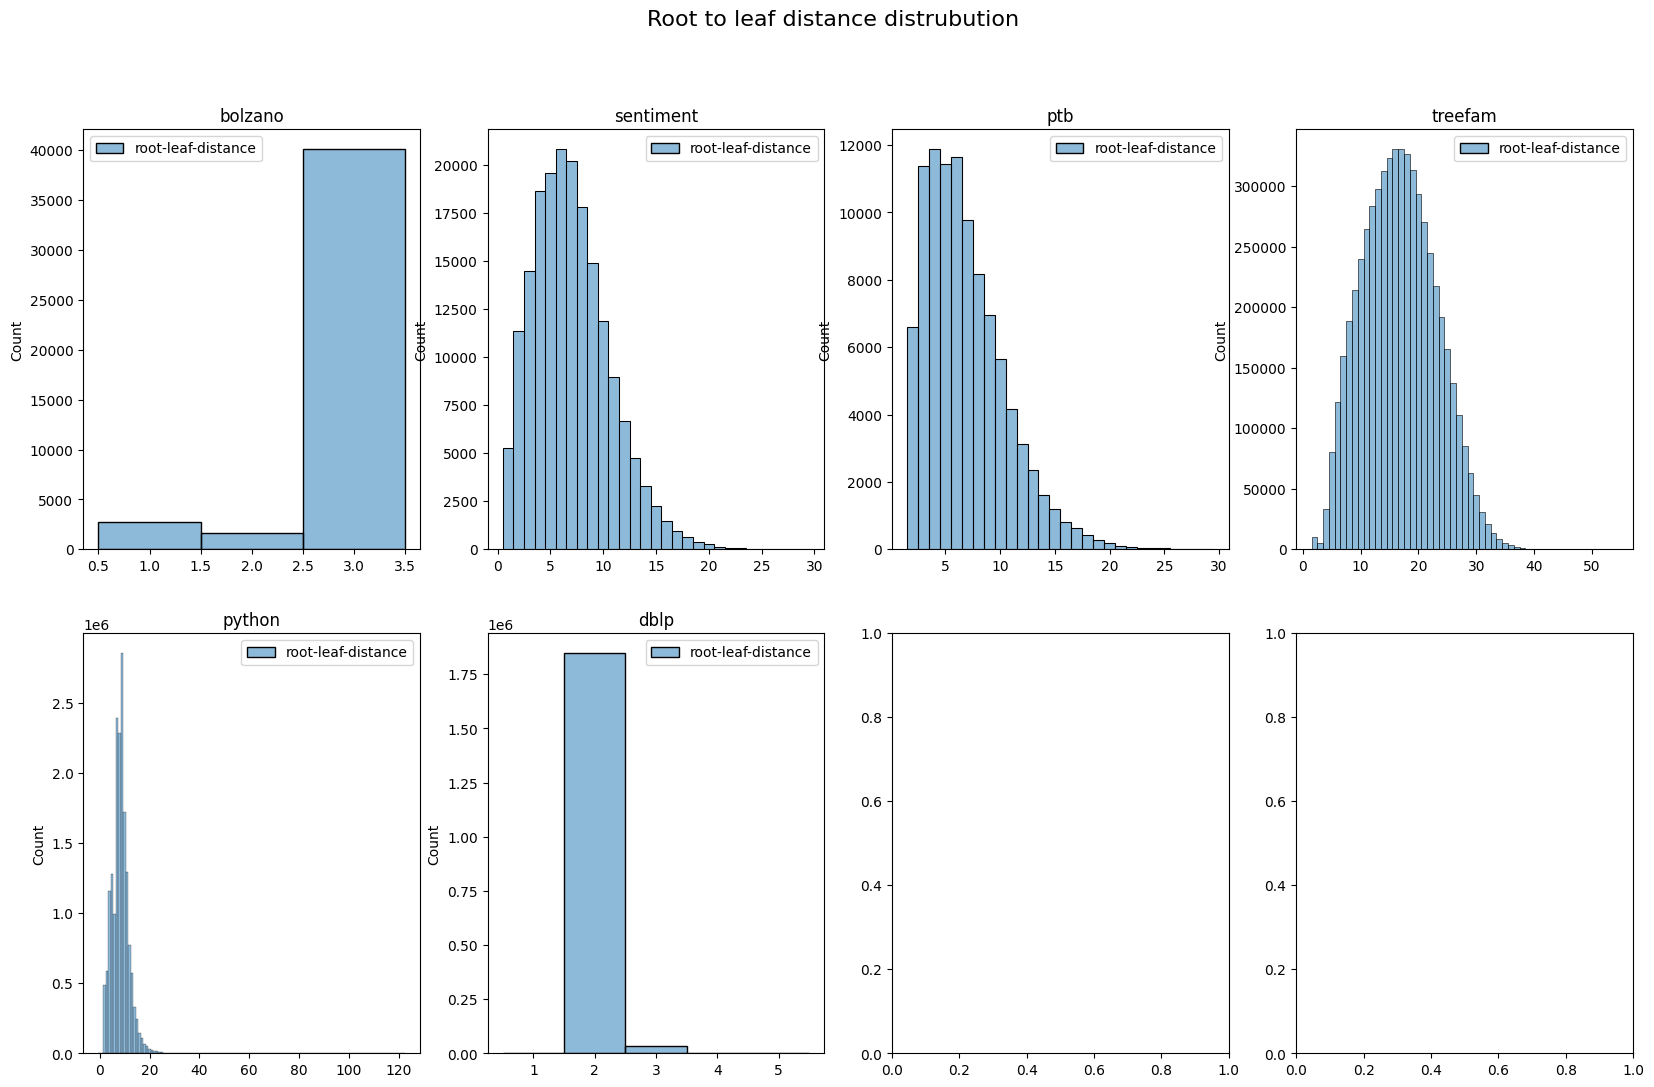

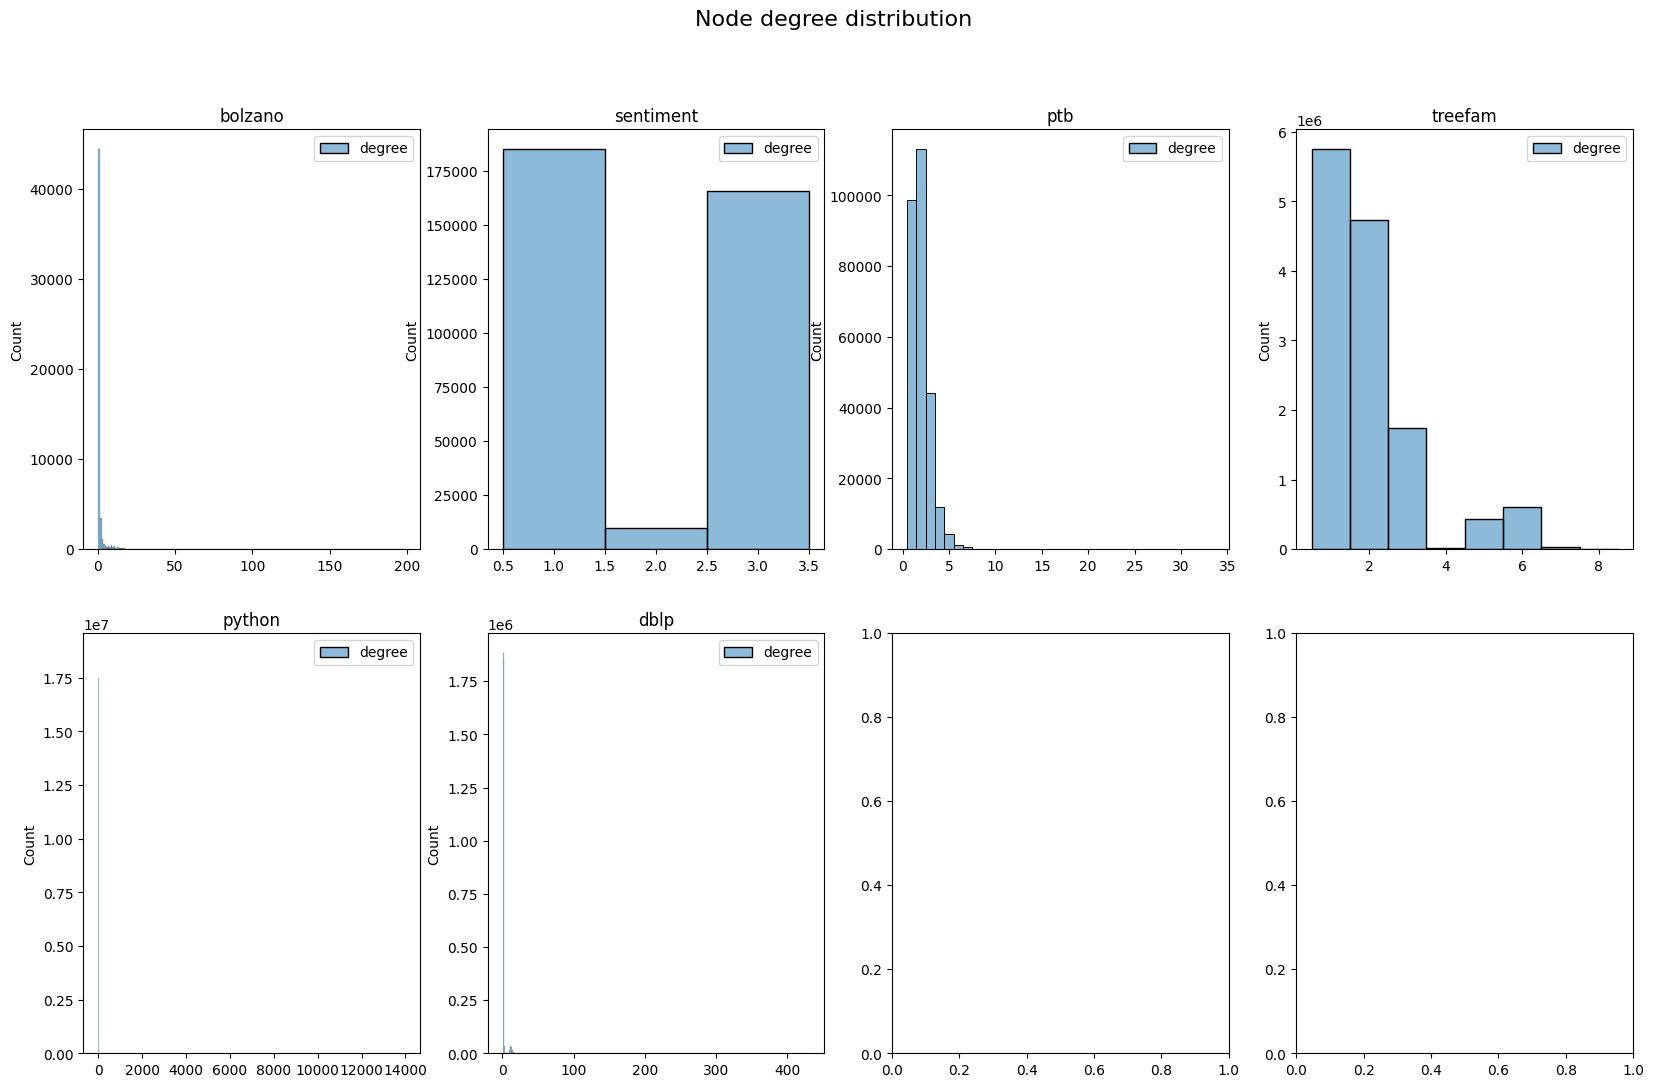

In [20]:
def load_stats(dataset: str):
    ds_path = join('./resources/statistics', dataset.lower())
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(6, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(6, 'Min node degree', [degrees['degree'].min()])
    df.insert(6, 'Max node degree', [degrees['degree'].max()])
    df.insert(9, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(9, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(9, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

f, axes = plt.subplots(2, 4, figsize=(20, 12))
f2, axes2 = plt.subplots(2, 4, figsize=(20, 12))
f.suptitle('Root to leaf distance distrubution', fontsize=16)
f2.suptitle('Node degree distribution', fontsize=16)
df = pd.DataFrame()
for i, (ds, _) in enumerate(tested_values):
    row = int(i >= 4)
    col = i % 4
    loaded, dep, deg = load_stats(ds)
    hp = sns.histplot(data=dep, ax=axes[row][col], discrete=True)
    hp.set(title=ds)
    hp2 = sns.histplot(data=deg, ax=axes2[row][col], discrete=True)
    hp2.set(title=ds)
    df = pd.concat([df, loaded])

pd.set_option('display.precision', 3)

df.reset_index()
df = df.rename(columns={
    'mint': 'Min tree size',
    'maxt': 'Max tree size',
    'avgt': 'Average tree size',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})
display(df)

In [156]:
def load_verification_times(dataset: str, threshold: int):
    runtime_df, absolute_df, lb_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    empty = True
    for lb_method in ALGORITHMS.keys():
        # print(lb_method)
        apted_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-apted-verification-times-ns.csv')
        topdiff_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-topdiff-verification-times-ns.csv')
    
        apted_df = pd.read_csv(apted_times, skiprows=2, names=["apted-verification-nanos"])
        topdiff_df = pd.read_csv(topdiff_times, skiprows=2, names=["topdiff-verification-nanos"])
        df = apted_df.join(topdiff_df).join(dataframes[dataset][lb_method][2])
        df['query_filter_time_nanos'] = df['query_filter_time_us'] * 1000
        
        df['lb_method'] = lb_method

        # runtime is in MS
        rtdf = pd.DataFrame.from_records([
            (
                (df['apted-verification-nanos'].sum() / 1000 / 1000),
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000),
                df['query_filter_time_us'].sum() / 1000,
                (df['apted-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                lb_method
            )
        ] , columns=['apted-candidates', 'topdiff-candidates', 'lb-runtime', 'apted-runtime', 'topdiff-runtime', 'lb_method'])
        
        v_vars=['apted-runtime', 'topdiff-runtime']
        
        # total_runtime = df.melt(
        #     value_vars=v_vars, id_vars=['lb_method'], var_name='verification-method', value_name='runtime'
        # )
        
        melted_absolute = df.melt(
            value_vars=['apted-verification-nanos', 'topdiff-verification-nanos'], id_vars=['lb_method'], var_name='verification-method', value_name='nanos'
        )

        melted_lb = df.melt(value_vars=['query_filter_time_us'], id_vars=['lb_method'], value_name='lb_time')
        
        if empty:
            runtime_df = rtdf
            absolute_df = melted_absolute
            lb_df = melted_lb
            empty = False
        else:
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            runtime_df = pd.concat([runtime_df, rtdf], ignore_index=True)
            absolute_df = pd.concat([absolute_df, melted_absolute], ignore_index=True)
            lb_df = pd.concat([lb_df, melted_lb], ignore_index=True)
        # df['lb-apted-perc'] = 100 - df['apted-perc']
        # df['lb-topdiff-perc'] =  100 - df['topdiff-perc'] 
    
    return runtime_df, absolute_df, lb_df
    ...

In [158]:
runtime, melted_absolute, lb_df = load_verification_times('bolzano', 6)

In [120]:
humanfriendly.format_timespan(timedelta(milliseconds=3810159.25010))

'1 hour, 3 minutes and 30.16 seconds'

# Verification time (TED time) % of complete LB + verification time

The lower the verification time %, the faster the LB method was in comparison to verification by using
either exact TED (APTED) or using bounded-TED (topdiff)

Loading  bolzano , t = 6 0
Loading  sentiment , t = 10 1
Loading  ptb , t = 15 2
Loading  treefam , t = 60 3
Loading  python , t = 15 4
Loading  dblp , t = 6 5


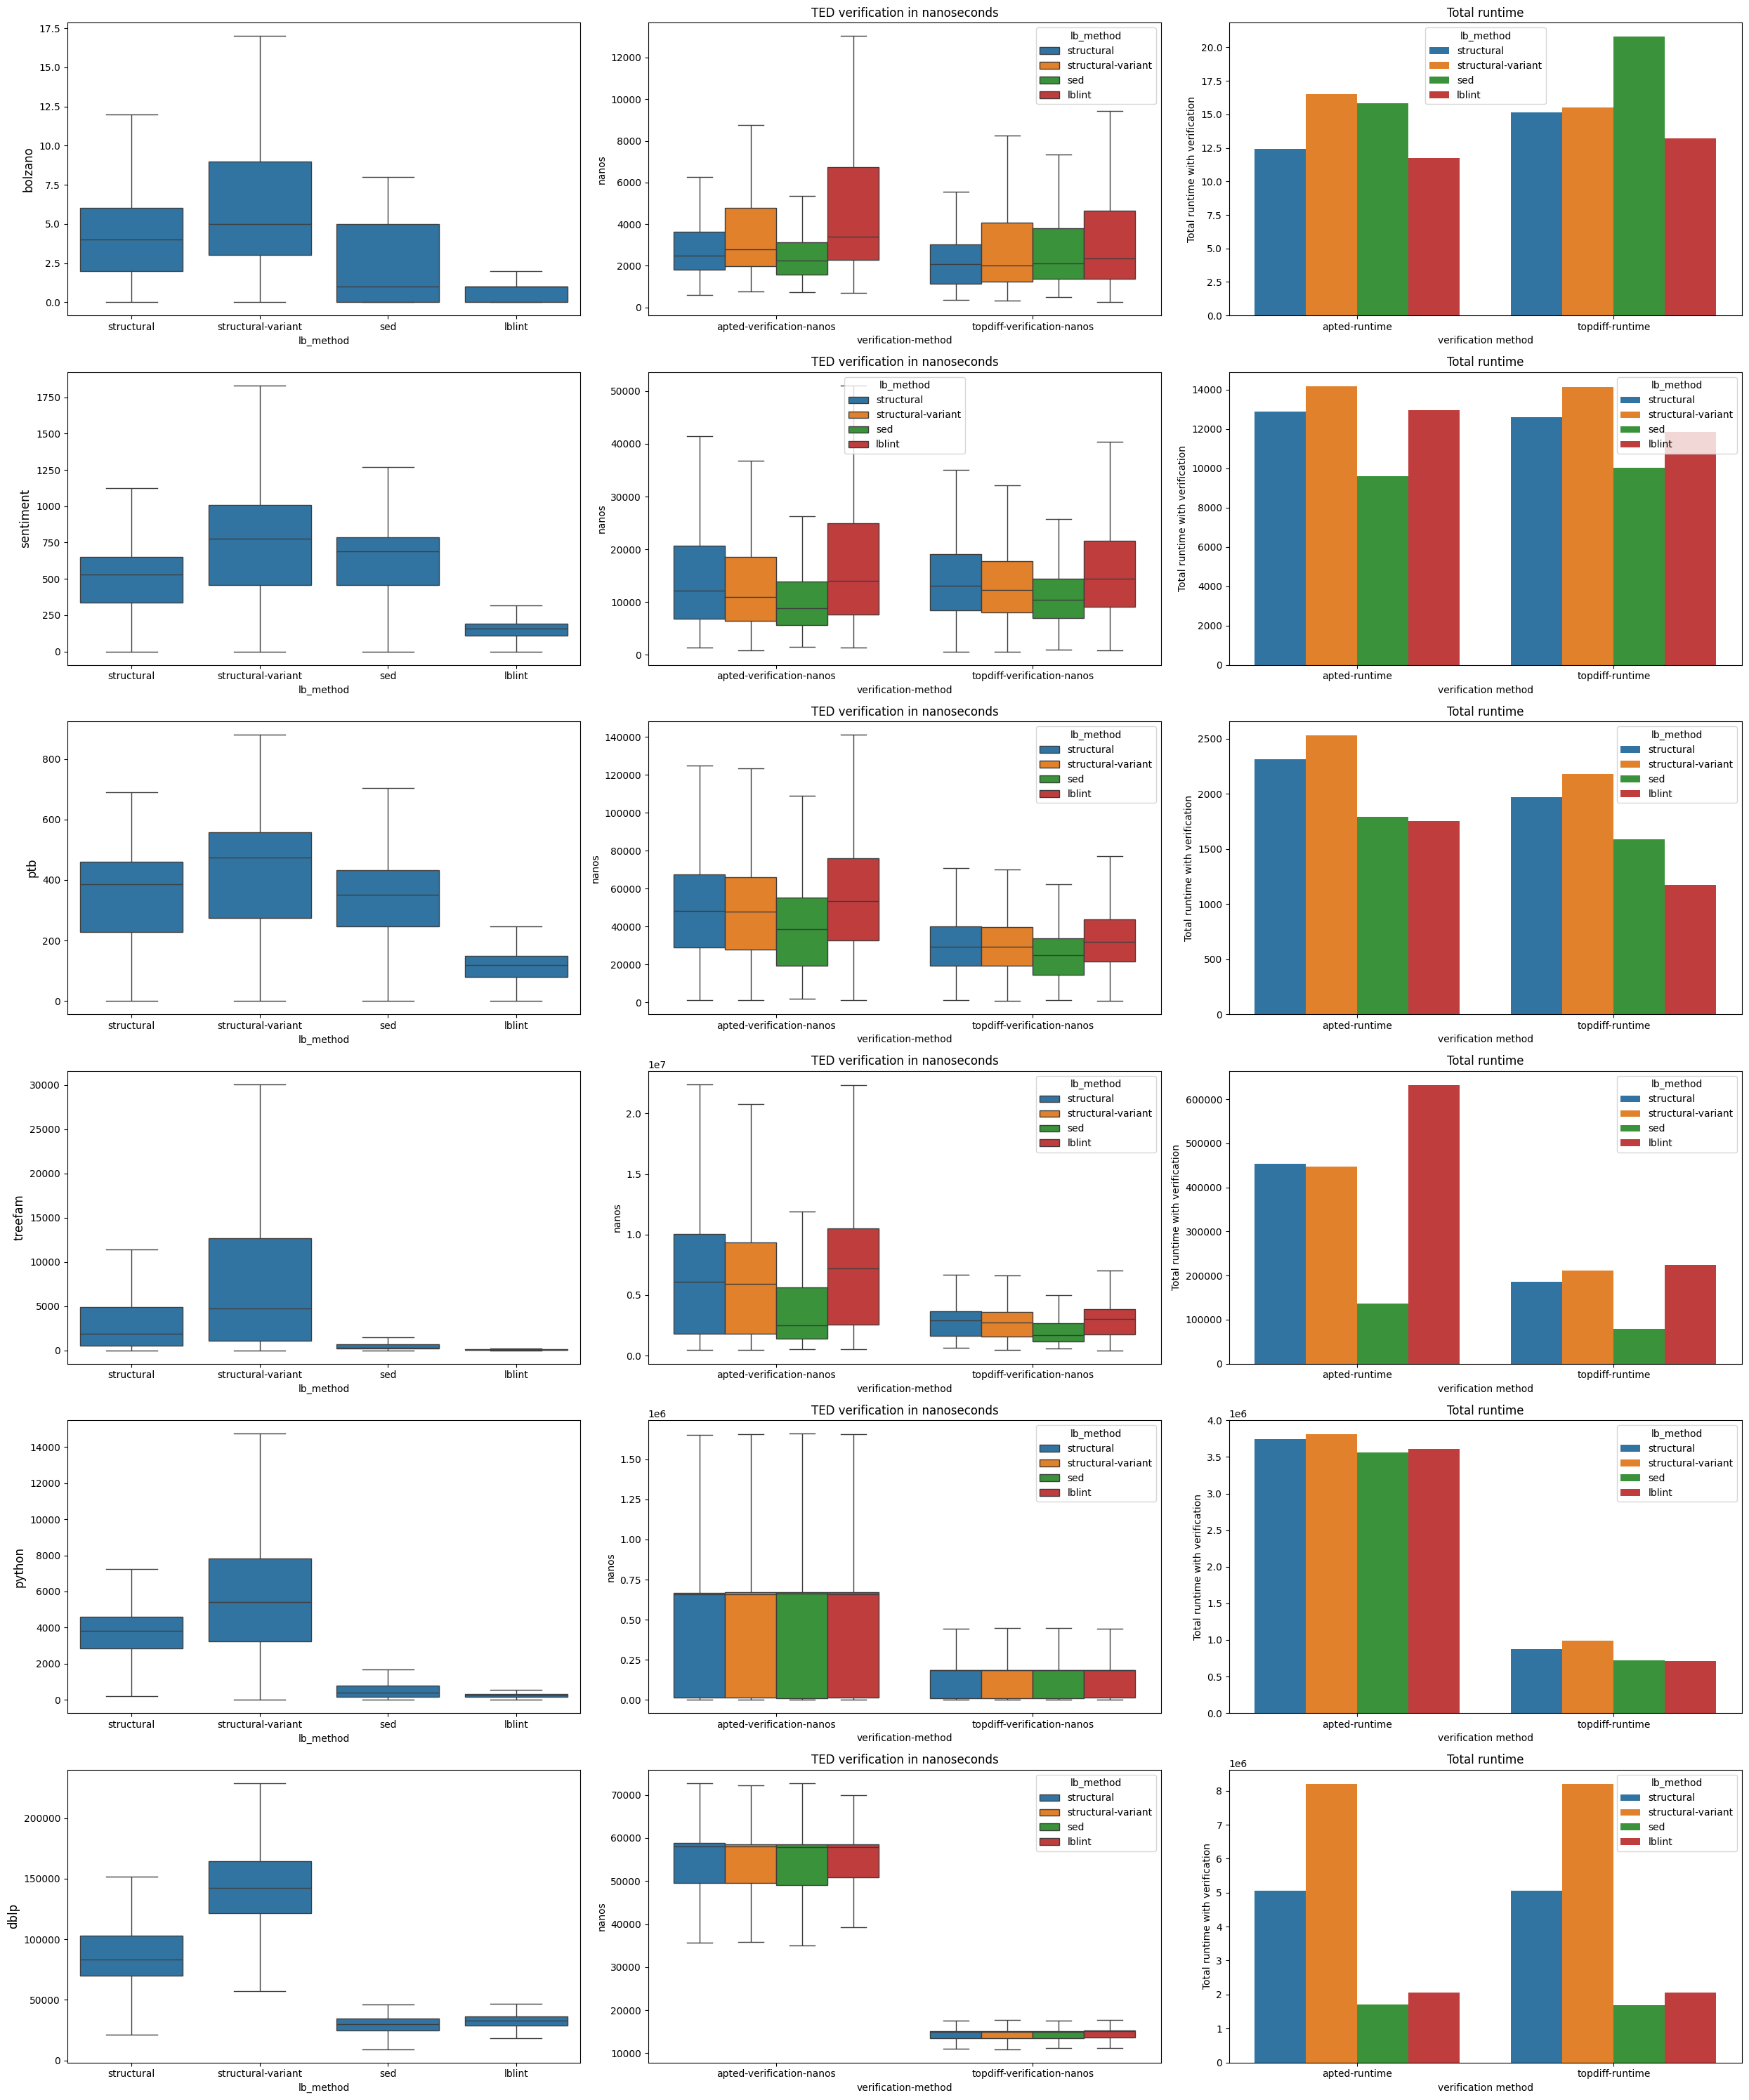

In [161]:
len_tested = len(tested_values)
fig, axes = plt.subplots(len_tested, 3, figsize=(25, 30))
# http://localhost:8888/lab/tree/TED-viz.ipynb#Verification-time-(TED-time)-%-of-complete-LB-+-verification-time
for i, (ds, t) in enumerate(tested_values):
    print('Loading ', ds, ', t =', t, i)
    runtime, melted_absolute, lb_df = load_verification_times(ds, t)
    # fig.suptitle('Bolzano')
    sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=axes[i, 0])
    # axes[i, 0].set_title('LB comp time in nanoseconds')
    sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=axes[i, 1])
    axes[i, 1].set_title('TED verification in nanoseconds')
    rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')
    sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=axes[i, 2])
    axes[i, 2].set_title('Total runtime')
    axes[i, 2].set_ylabel('Total runtime with verification')

for ax, (ds, _) in zip(axes[:, 0], tested_values):
    ax.set_ylabel(ds, size='large')

plt.tight_layout()
plt.show()

Printing  bolzano
Printing  sentiment


/home/lukas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Printing  ptb
Printing  treefam
Printing  python
Printing  dblp


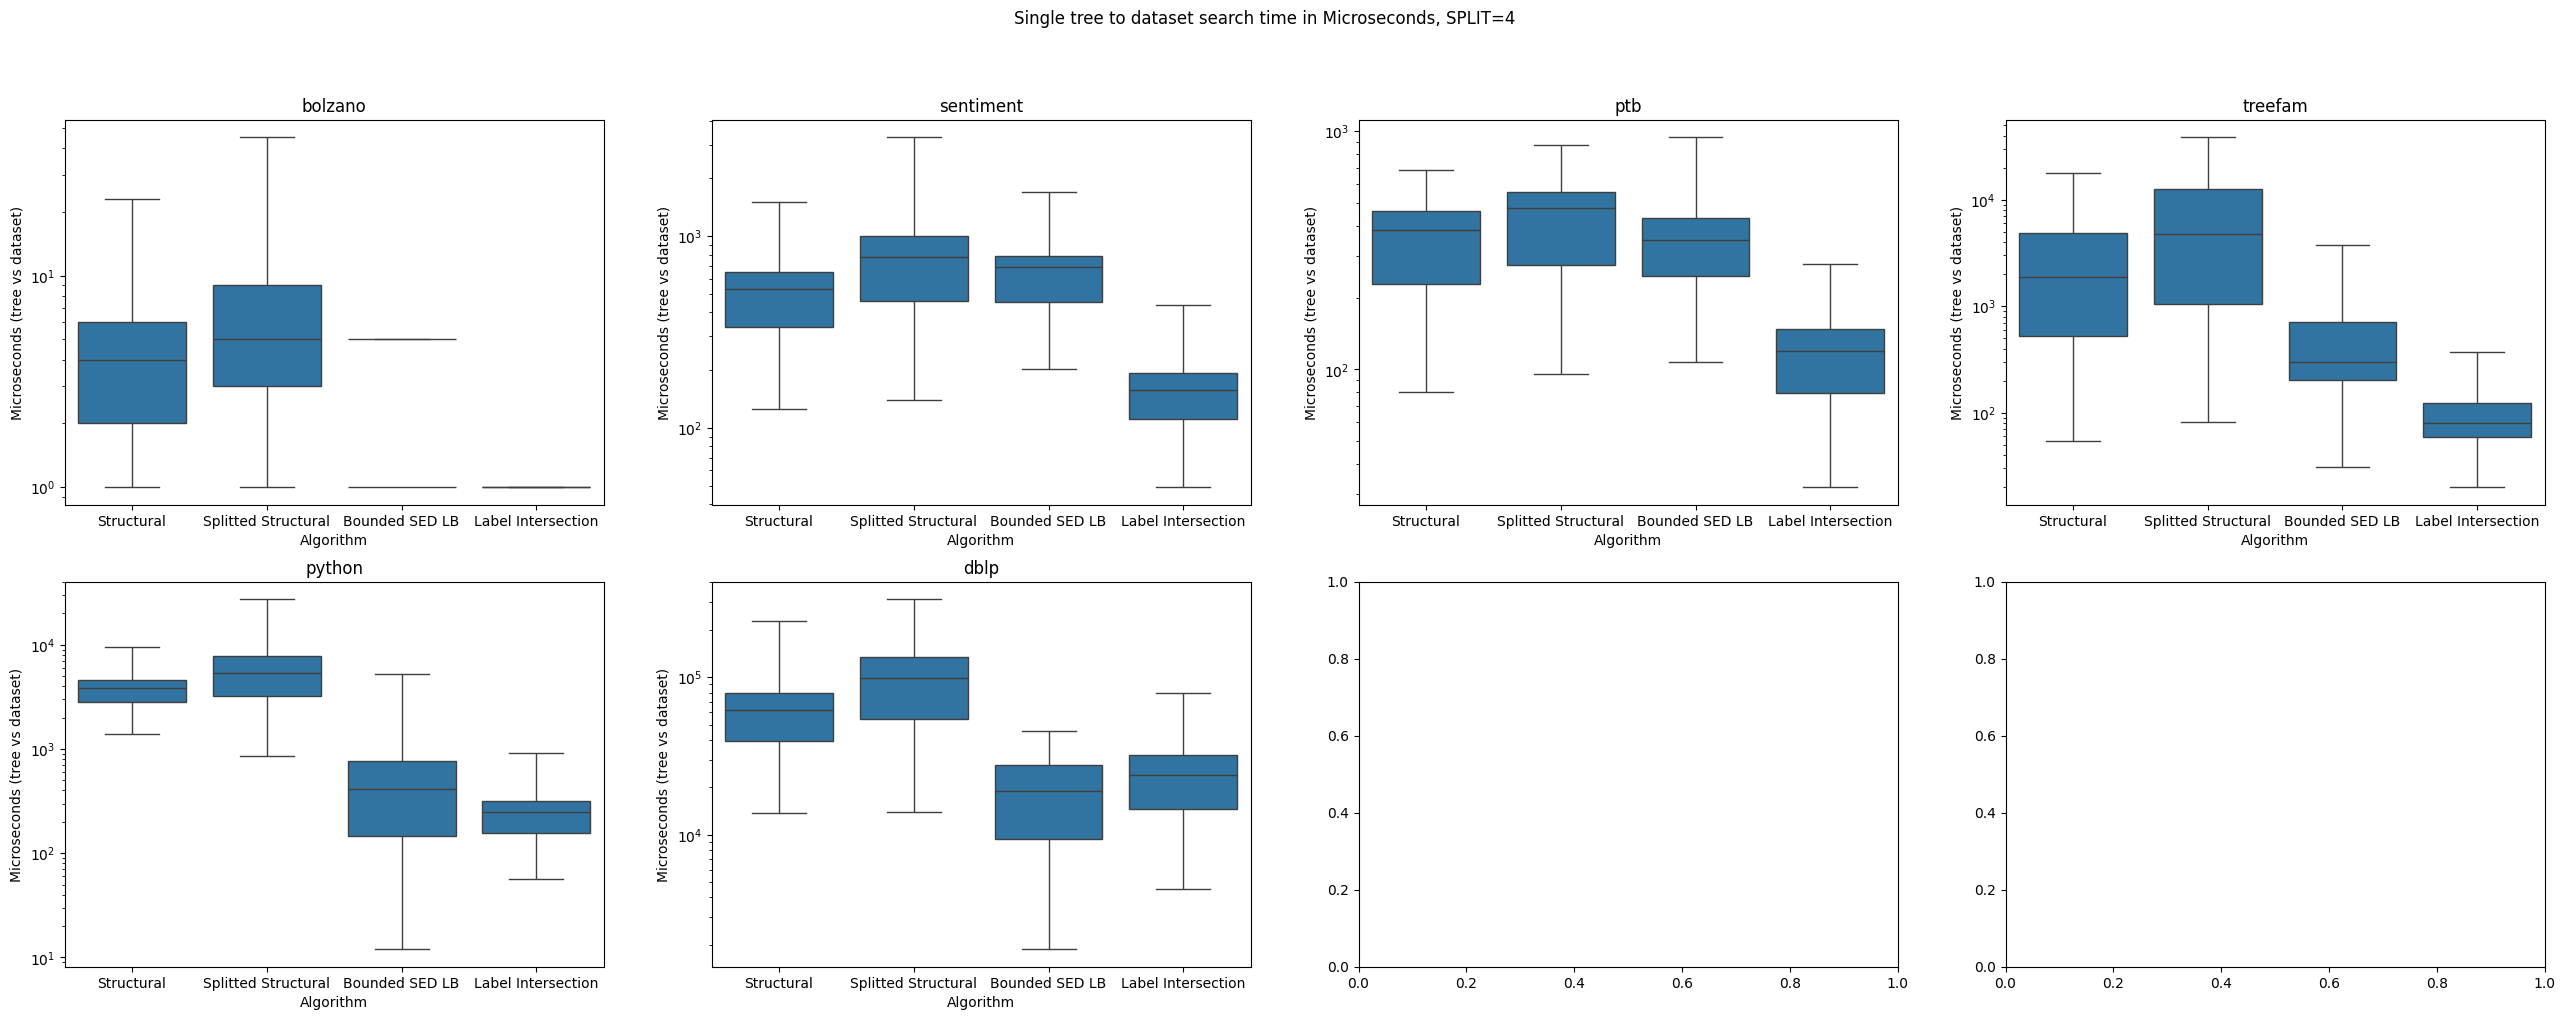

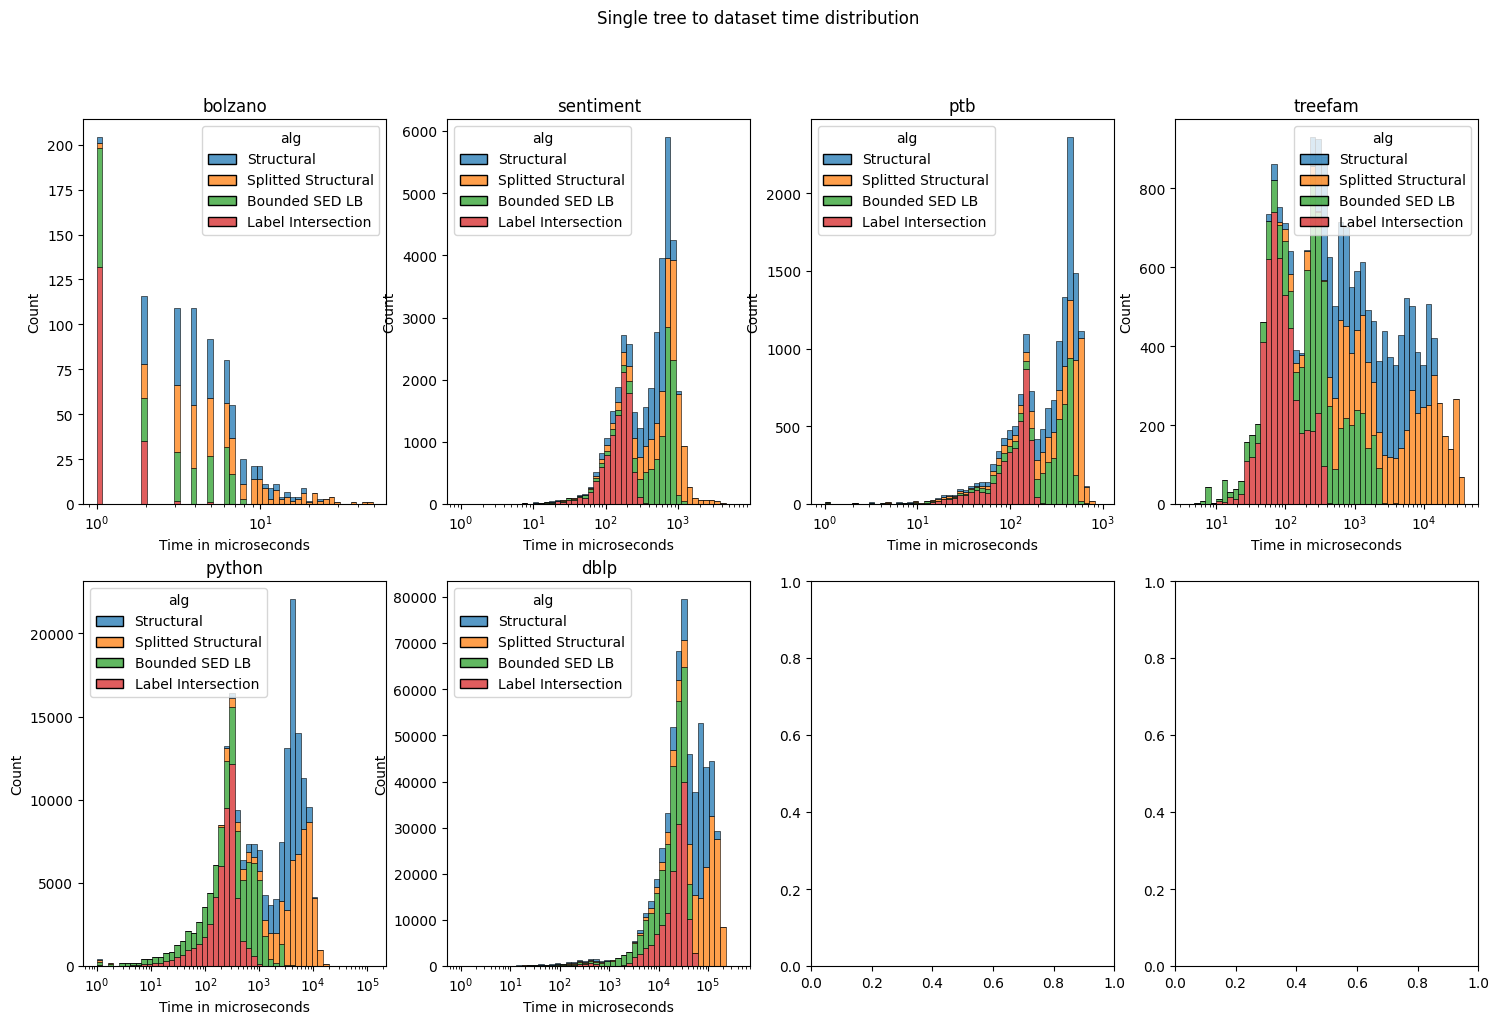

In [164]:
f, axes = plt.subplots(2, 4, figsize=(32, 11))
f.suptitle('Single tree to dataset search time in Microseconds, SPLIT=4')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)

    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = ALGORITHMS[alg]
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

,Correct trees,Extra trees,Precision,Mean Selectivity,Algorithm,Dataset
0,57580,4389,0.92917,0.0002911%,Label Intersection,dblp


Algorithm,Bounded SED LB,Label Intersection,Splitted Structural,Structural
Dataset,,,,
bolzano,0.79381,0.57570,0.73861,0.69213
dblp,0.99972,0.92917,0.99782,0.99700
ptb,0.86878,0.50880,0.62274,0.59425
python,0.95190,0.92116,0.93404,0.93102
sentiment,0.56108,0.33283,0.42183,0.37923
treefam,0.99583,0.46474,0.57123,0.56897


[Text(0.5, 1.0, 'Precision heatmap, SPLIT=4')]

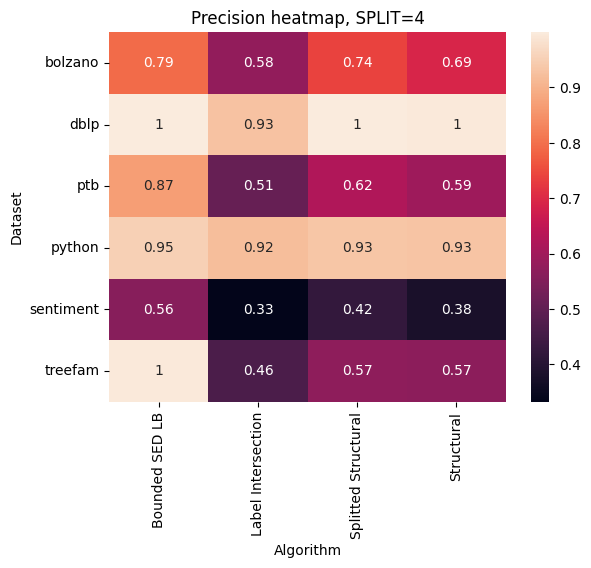

In [165]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Precision heatmap, SPLIT=4')

In [179]:
summary = dataframes[ds][alg][1].copy()
summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
summary

,Correct trees,Extra trees,Precision,Mean Selectivity
0,57580,4389,0.92917,0.0002911


Algorithm,Bounded SED LB,Label Intersection,Splitted Structural,Structural
Dataset,,,,
bolzano,0.00449,0.00633,0.00485,0.00519
dblp,0.00000,0.00000,0.00000,0.00000
ptb,0.00077,0.00133,0.00108,0.00113
python,0.00405,0.00405,0.00405,0.00405
sentiment,0.00342,0.00592,0.00460,0.00514
treefam,0.00133,0.00294,0.00237,0.00238


[Text(0.5, 1.0, 'Selectivity heatmap, SPLIT=4')]

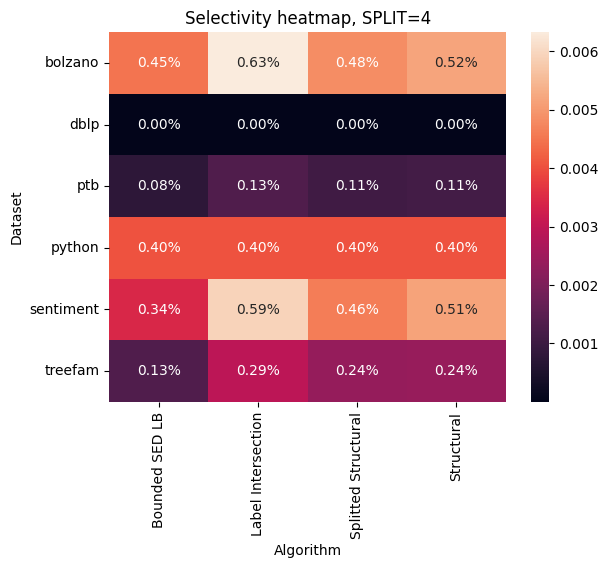

In [190]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds
        summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
        summary = summary.astype({'Mean Selectivity': 'float64'})
        summary['Mean Selectivity'] = summary['Mean Selectivity'] / 100
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Mean Selectivity").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True, fmt='.2%')
hp.set(title='Selectivity heatmap, SPLIT=4')

In [ ]:
dataframes = dict()
tested_values = [('sentiment', 5), ('sentiment', 15), ('sentiment', 20), ('sentiment', 10)]
dataframes['sentiment'] = dict()
for ds, t in tested_values:
    dataframes[ds][t] = load_dataset(ds, t)

,Correct trees,Extra trees,Precision,Algorithm,Threshold
0,173295,346429,0.333437,Label Intersection,10


Threshold,5,10,15,20
Algorithm,,,,
Bounded SED LB,0.755884,0.562106,0.531252,0.714993
Label Intersection,0.429923,0.333437,0.311100,0.421020
Splitted Structural,0.584731,0.421961,0.393487,0.518558
Structural,0.516448,0.380023,0.367358,0.483257


[Text(0.5, 1.0, 'Sentiment Precision heatmap, SPLIT=4')]

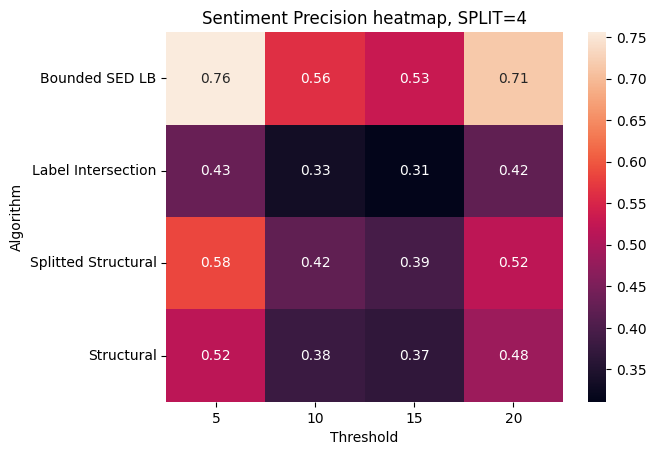

In [59]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds][x].keys():
        summary = dataframes[ds][x][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Threshold'] = x
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Algorithm", columns="Threshold", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Sentiment Precision heatmap, SPLIT=4')

In [6]:
selectivities = [('sentiment', 0.0746, 5), ('sentiment', 0.859, 10), ('sentiment', 3.04574, 15), ('sentiment', 8.496, 20)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,sentiment,0.07460,5
1,sentiment,0.85900,10
2,sentiment,3.04574,15
3,sentiment,8.49600,20


In [76]:
df = pd.read_csv('./python-Structural-times-us.txt', header=None, names=["LB time"])

In [77]:
df['LB time'].sum() / 1000 / 1000

168.53804300000002

In [78]:
df = pd.read_csv('./resources/results/python/15/python-Structural-times-us.txt', header=None, names=["LB time"])

In [79]:
df['LB time'].sum() / 1000 / 1000

186.34054999999998